# Legal Document Classification with Supervised Learning
We will use the dataset from https://huggingface.co/datasets/AI-team-UoA/greek_legal_code which contains 47k documents. Each one has three labels:

1. Chapter
2. Subject
3. Volume

We will implement the following algorithms:

1. SVM with BoW and TF-IDF
2. Logistic Regression with Word2Vec and FastText
3. K-nn with FastText

In [12]:
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

### We first need to gather the data
We get three dataframes, each one having two columns **text** and **label**. The label column is different between dataframes representing chapter, subject and volume (as described earlier) in each one.

In [2]:
chapter_splits = {'train': 'chapter/train-00000-of-00001.parquet', 'test': 'chapter/test-00000-of-00001.parquet', 'validation': 'chapter/validation-00000-of-00001.parquet'}
chapter_train_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + chapter_splits["train"])
chapter_test_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + chapter_splits["test"])
chapter_val_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + chapter_splits["validation"])

subject_splits = {'train': 'subject/train-00000-of-00001.parquet', 'test': 'subject/test-00000-of-00001.parquet', 'validation': 'subject/validation-00000-of-00001.parquet'}
subject_train_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + subject_splits["train"])
subject_test_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + subject_splits["test"])
subject_val_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + subject_splits["validation"])

volume_splits = {'train': 'volume/train-00000-of-00001.parquet', 'test': 'volume/test-00000-of-00001.parquet', 'validation': 'volume/validation-00000-of-00001.parquet'}
volume_train_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + volume_splits["train"])
volume_test_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + volume_splits["test"])
volume_val_df = pd.read_parquet("hf://datasets/AI-team-UoA/greek_legal_code/" + volume_splits["validation"])

In [3]:
X_train = chapter_train_df['text']
X_test = chapter_test_df['text']
X_val = chapter_val_df['text']

# chapter
y_chapter_train = chapter_train_df['label']
y_chapter_test = chapter_test_df['label']
y_chapter_val = chapter_val_df['label']

# subject
y_subject_train = subject_train_df['label']
y_subject_test = subject_test_df['label']
y_subject_val = subject_val_df['label']

# volume
y_volume_train = volume_train_df['label']
y_volume_test = volume_test_df['label']
y_volume_val = volume_val_df['label']

print("(Chapter) Training data shape:", X_train.shape, y_chapter_train.shape)
print("(Chapter) Validation data shape:", X_val.shape, y_chapter_val.shape)
print("(Chapter) Testing data shape:", X_test.shape, y_chapter_test.shape)
print("\n(Subject) Training data shape:", X_train.shape, y_subject_train.shape)
print("(Subject) Validation data shape:", X_val.shape, y_subject_val.shape)
print("(Subject) Testing data shape:", X_test.shape, y_subject_test.shape)
print("\n(Volume) Training data shape:", X_train.shape, y_volume_train.shape)
print("(Volume) Validation data shape:", X_val.shape, y_volume_val.shape)
print("(Volume) Testing data shape:", X_test.shape, y_volume_test.shape)

(Chapter) Training data shape: (28536,) (28536,)
(Chapter) Validation data shape: (9511,) (9511,)
(Chapter) Testing data shape: (9516,) (9516,)

(Subject) Training data shape: (28536,) (28536,)
(Subject) Validation data shape: (9511,) (9511,)
(Subject) Testing data shape: (9516,) (9516,)

(Volume) Training data shape: (28536,) (28536,)
(Volume) Validation data shape: (9511,) (9511,)
(Volume) Testing data shape: (9516,) (9516,)


Let's see the class distribution for each label.

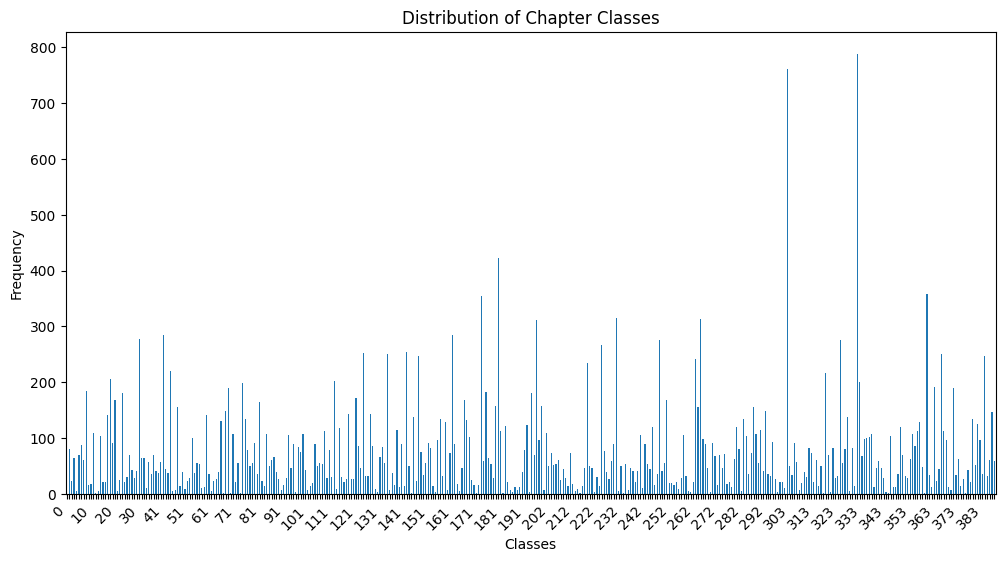

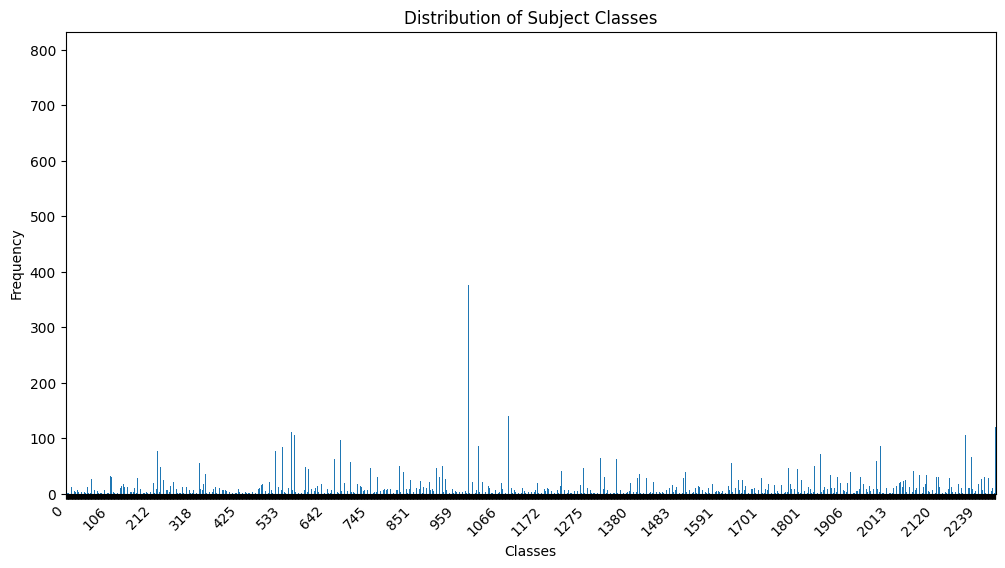

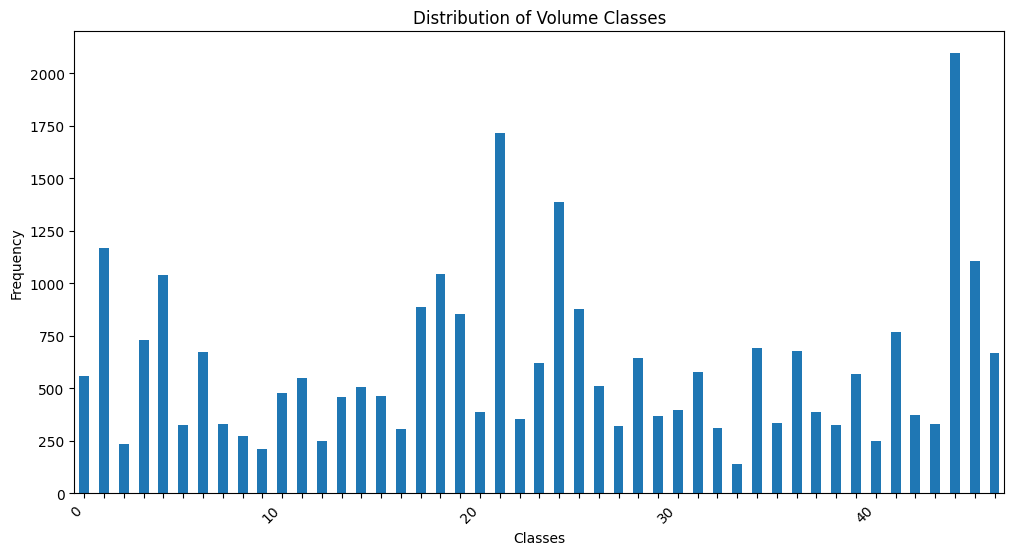

In [ ]:
def show_class_distr(y, label, fsize=(12, 6), skip_label=10):
  plt.figure(figsize=fsize)
  y.value_counts().sort_index().plot(kind='bar')
  plt.title(f'Distribution of {label} Classes')
  plt.xlabel('Classes')
  plt.ylabel('Frequency')
  locs, labels = plt.xticks()
  new_labels = [label.get_text() if i % skip_label == 0 else '' for i, label in enumerate(labels)]
  plt.xticks(locs, new_labels, rotation=45, ha='right')
  plt.show()

show_class_distr(y_chapter_train, "Chapter")
print()
show_class_distr(y_subject_train, "Subject", skip_label=100)
print()
show_class_distr(y_volume_train, "Volume")

## Support Vector Machines (SVM)

### Bag of words implementation
First we will do SVM using Bag of Words. We import the *CountVectorizer* class to help us create the vocabulary.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)

# vectorize X_train
X_train_cv = vectorizer.fit_transform(X_train.values) # create sparse matrix with the vocabulary created by fitting the vectorizer
X_train_cv

<28536x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 4249572 stored elements in Compressed Sparse Row format>

We could create a list with the most common words in our X_train and create a stop-words list, to exclude words that give very little information.

In [5]:
word_counts = X_train_cv.sum(axis=0).A1  # A1 flattens the matrix to a 1D array
feature_names = vectorizer.get_feature_names_out()
word_frequency = pd.Series(word_counts, index=feature_names)
most_common_words = word_frequency.sort_values(ascending=False) # sort by frequency in descending order

# Display the top N most common words
n_top_words = 100
print(f"The {n_top_words} most common words are:")
print(most_common_words.head(n_top_words))

The 100 most common words are:
του      667760
και      587758
της      505657
των      412737
την      291385
          ...  
αν        14936
14        14781
στα       14568
νόμου     14558
000       14160
Length: 100, dtype: int64


In [6]:
# create the vectorizer again after stop_words creation
vectorizer = CountVectorizer(stop_words=most_common_words.to_list(), max_features=10000)
X_train_cv = vectorizer.fit_transform(X_train.values)
X_train_cv

<28536x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 4249572 stored elements in Compressed Sparse Row format>

**Find best C for SVM**</br>
We take random samples from our train and validation set in order to find the best C parameter for our SVM.

In [7]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from scipy.sparse import vstack

def custom_gridsearch(train, val, grid_params, label, model=SVC()):
  X_train_vectorized, y_train = train[0], train[1]
  X_val_vectorized, y_val = val[0], val[1]
  # create PredefinedSplit object: -1 if the sample is from X_train, 0 if the sample is from X_val
  split_index = [-1] * X_train_vectorized.shape[0] + [0] * X_val_vectorized.shape[0]
  pds = PredefinedSplit(test_fold=split_index)
  # combine training and validation data for PredefinedSplit
  X_combined = vstack([X_train_vectorized, X_val_vectorized])
  y_combined = np.hstack((y_train, y_val))

  # initialize GridSearchCV with PredefinedSplit
  grid_search = GridSearchCV(model, grid_params, cv=pds, scoring='accuracy', verbose=2, n_jobs=-1)
  grid_search.fit(X_combined, y_combined)

  best_params = []
  for param in grid_params:
    print(f"({label}) Best {param} value: {grid_search.best_params_[param]}")
    best_params.append(grid_search.best_params_[param])
  print(f"({label}) Best cross-validation accuracy: {grid_search.best_score_}")


  return best_params, grid_search.best_estimator_

In [8]:
# take samples from train and val data
# chapter
train_df_sampled = chapter_train_df.sample(frac=0.2, random_state=42)
val_df_sampled = chapter_val_df.sample(frac=0.2, random_state=42)
test_df_sampled = chapter_test_df.sample(frac=0.2, random_state=42)
X_chapter_sampled_train = train_df_sampled['text']
X_chapter_sampled_val = val_df_sampled['text']
X_chapter_sampled_test = test_df_sampled['text']
y_chapter_sampled_train = train_df_sampled['label']
y_chapter_sampled_val = val_df_sampled['label']
y_chapter_sampled_test = test_df_sampled['label']

# subject
train_df_sampled = subject_train_df.sample(frac=0.2, random_state=42)
val_df_sampled = subject_val_df.sample(frac=0.2, random_state=42)
test_df_sampled = subject_test_df.sample(frac=0.2, random_state=42)
X_subject_sampled_train = train_df_sampled['text']
X_subject_sampled_val = val_df_sampled['text']
X_subject_sampled_test = test_df_sampled['text']
y_subject_sampled_train = train_df_sampled['label']
y_subject_sampled_val = val_df_sampled['label']
y_subject_sampled_test = test_df_sampled['label']

# volume
train_df_sampled = volume_train_df.sample(frac=0.2, random_state=42)
val_df_sampled = volume_val_df.sample(frac=0.2, random_state=42)
test_df_sampled = volume_test_df.sample(frac=0.2, random_state=42)
X_volume_sampled_train = train_df_sampled['text']
X_volume_sampled_val = val_df_sampled['text']
X_volume_sampled_test = test_df_sampled['text']
y_volume_sampled_train = train_df_sampled['label']
y_volume_sampled_val = val_df_sampled['label']
y_volume_sampled_test = test_df_sampled['label']

In [13]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} # define parameter grid for SVC

# vectorize the samples and run gridsearch
sampled_vectorizer = CountVectorizer(stop_words=most_common_words.to_list(), max_features=10000)

# chapter
X_sampled_train_cv = sampled_vectorizer.fit_transform(X_chapter_sampled_train.values)
X_sampled_val_cv = sampled_vectorizer.transform(X_chapter_sampled_val.values)
chapter_C, svm_model_chapter = custom_gridsearch((X_sampled_train_cv, y_chapter_sampled_train), (X_sampled_val_cv, y_chapter_sampled_val), param_grid, "Chapter", model=LinearSVC())

# subject
X_sampled_train_cv = sampled_vectorizer.fit_transform(X_subject_sampled_train.values)
X_sampled_val_cv = sampled_vectorizer.transform(X_subject_sampled_val.values)
subject_C, svm_model_subject = custom_gridsearch((X_sampled_train_cv, y_subject_sampled_train), (X_sampled_val_cv, y_subject_sampled_val), param_grid, "Subject", model=LinearSVC())

# volume
X_sampled_train_cv = sampled_vectorizer.fit_transform(X_volume_sampled_train.values)
X_sampled_val_cv = sampled_vectorizer.transform(X_volume_sampled_val.values)
volume_C, svm_model_volume = custom_gridsearch((X_sampled_train_cv, y_volume_sampled_train), (X_sampled_val_cv, y_volume_sampled_val), param_grid, "Volume", model=LinearSVC())

Fitting 1 folds for each of 6 candidates, totalling 6 fits
(Chapter) Best C value: 0.1
(Chapter) Best cross-validation accuracy: 0.4952681388012618
Fitting 1 folds for each of 6 candidates, totalling 6 fits
(Subject) Best C value: 0.1
(Subject) Best cross-validation accuracy: 0.3401682439537329
Fitting 1 folds for each of 6 candidates, totalling 6 fits
(Volume) Best C value: 0.01
(Volume) Best cross-validation accuracy: 0.6640378548895899


After finding the best C hyperparameter for each of our labels, we can then test the model on the test dataset.

In [10]:
from sklearn.metrics import classification_report

def class_report(y_true, y_pred):
  report_dict = classification_report(y_true, y_pred, zero_division=0.0, output_dict=True)

  # Extract the micro, macro, and weighted average
  accuracy = report_dict['accuracy']
  macro_avg = report_dict['macro avg']
  weighted_avg = report_dict['weighted avg']

  # Print the desired averages
  print(f"\nAccuracy: {accuracy}")

  print("\nMacro Average:")
  print(f"  Precision: {macro_avg['precision']:.4f}")
  print(f"  Recall: {macro_avg['recall']:.4f}")
  print(f"  F1-score: {macro_avg['f1-score']:.4f}")
  print(f"  Support: {macro_avg['support']}")

  print("\nWeighted Average:")
  print(f"  Precision: {weighted_avg['precision']:.4f}")
  print(f"  Recall: {weighted_avg['recall']:.4f}")
  print(f"  F1-score: {weighted_avg['f1-score']:.4f}")
  print(f"  Support: {weighted_avg['support']}")

In [14]:
# vectorize X_test
X_sampled_chapter_test_cv = sampled_vectorizer.transform(X_chapter_sampled_test.values)
X_subject_sampled_test_cv = sampled_vectorizer.transform(X_subject_sampled_test.values)
X_volume_sampled_test_cv = sampled_vectorizer.transform(X_volume_sampled_test.values)

# predict
y_pred = svm_model_chapter.predict(X_sampled_chapter_test_cv)
print("Chapter:")
print(classification_report(y_chapter_sampled_test, y_pred))

y_pred = svm_model_subject.predict(X_subject_sampled_test_cv)
print("\n\nSubject:")
print(classification_report(y_subject_sampled_test, y_pred))

y_pred = svm_model_volume.predict(X_volume_sampled_test_cv)
print("\n\nVolume:")
print(classification_report(y_volume_sampled_test, y_pred))

Chapter:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         0
           3       0.33      0.80      0.47         5
           5       0.57      1.00      0.73         4
           6       0.00      0.00      0.00         2
           7       0.25      0.25      0.25         8
           8       0.38      0.50      0.43        12
          10       1.00      0.33      0.50         3
          11       0.62      0.83      0.71         6
          14       0.60      0.60      0.60         5
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         1
          17       1.00      0.67      0.80        12
          18       0.40      0.36      0.38        11
          19       1.00      0.71      0.83         7
          20       0.50      0.67      0.57        12
          21      

### TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize the samples and run gridsearch
tfidf_sampled_vectorizer = TfidfVectorizer(stop_words=most_common_words.to_list(), max_features=10000)

# chapter
X_sampled_train_tfv = tfidf_sampled_vectorizer.fit_transform(X_chapter_sampled_train.values)
X_sampled_val_tfv = tfidf_sampled_vectorizer.transform(X_chapter_sampled_val.values)
chapter_C, svm_model_chapter = custom_gridsearch((X_sampled_train_tfv, y_chapter_sampled_train), (X_sampled_val_tfv, y_chapter_sampled_val), param_grid, "Chapter", model=LinearSVC())

# subject
X_sampled_train_tfv = tfidf_sampled_vectorizer.fit_transform(X_subject_sampled_train.values)
X_sampled_val_tfv = tfidf_sampled_vectorizer.transform(X_subject_sampled_val.values)
subject_C, svm_model_subject = custom_gridsearch((X_sampled_train_tfv, y_subject_sampled_train), (X_sampled_val_tfv, y_subject_sampled_val), param_grid, "Subject", model=LinearSVC())

# volume
X_sampled_train_tfv = tfidf_sampled_vectorizer.fit_transform(X_volume_sampled_train.values)
X_sampled_val_tfv = tfidf_sampled_vectorizer.transform(X_volume_sampled_val.values)
volume_C, svm_model_volume = custom_gridsearch((X_sampled_train_tfv, y_volume_sampled_train), (X_sampled_val_tfv, y_volume_sampled_val), param_grid, "Volume", model=LinearSVC())

Fitting 1 folds for each of 6 candidates, totalling 6 fits
(Chapter) Best C value: 1
(Chapter) Best cross-validation accuracy: 0.61198738170347
Fitting 1 folds for each of 6 candidates, totalling 6 fits
(Subject) Best C value: 10
(Subject) Best cross-validation accuracy: 0.46635120925341744
Fitting 1 folds for each of 6 candidates, totalling 6 fits
(Volume) Best C value: 1
(Volume) Best cross-validation accuracy: 0.749211356466877


In [16]:
# vectorize X_test
X_sampled_chapter_test_cv = tfidf_sampled_vectorizer.transform(X_chapter_sampled_test.values)
X_sampled_subject_test_cv = tfidf_sampled_vectorizer.transform(X_subject_sampled_test.values)
X_sampled_volume_test_cv = tfidf_sampled_vectorizer.transform(X_volume_sampled_test.values)

# predict
y_pred = svm_model_chapter.predict(X_sampled_chapter_test_cv)
print("Chapter:")
print(classification_report(y_chapter_sampled_test, y_pred))

y_pred = svm_model_subject.predict(X_sampled_subject_test_cv)
print("\n\nSubject:")
print(classification_report(y_subject_sampled_test, y_pred))

y_pred = svm_model_volume.predict(X_sampled_volume_test_cv)
print("\n\nVolume:")
print(classification_report(y_volume_sampled_test, y_pred))

Chapter:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         0
           3       0.67      0.80      0.73         5
           5       0.57      1.00      0.73         4
           6       0.12      0.50      0.20         2
           7       0.67      0.25      0.36         8
           8       0.62      0.67      0.64        12
          10       1.00      0.33      0.50         3
          11       0.75      1.00      0.86         6
          14       0.75      0.60      0.67         5
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.89      0.67      0.76        12
          18       0.67      0.55      0.60        11
          19       1.00      0.71      0.83         7
          20       0.53      0.75      0.62        12
          21      

## Logistic Regression

In [17]:
import gensim
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
from sklearn.model_selection import train_test_split

# get a sample of the data
X_train_sampled, _, y_chapter_sampled_train, _, y_subject_sampled_train, _, y_volume_sampled_train, _ = train_test_split(X_train, y_chapter_train, y_subject_train, y_volume_train, train_size=0.2, random_state=42)
X_val_sampled, _, y_chapter_sampled_val, _, y_subject_sampled_val, _, y_volume_sampled_val, _ = train_test_split(X_val, y_chapter_val, y_subject_val, y_volume_val, train_size=0.2, random_state=42)
X_test_sampled, _, y_chapter_sampled_test, _, y_subject_sampled_test, _, y_volume_sampled_test, _ = train_test_split(X_test, y_chapter_test, y_subject_test, y_volume_test, train_size=0.2, random_state=42)

### Word2Vec

In [19]:
tokenized_X_train_sampled = [word_tokenize(text.lower()) for text in X_train_sampled]
tokenized_X_val_sampled = [word_tokenize(text.lower()) for text in X_val_sampled]
tokenized_X_test_sampeld = [word_tokenize(text.lower()) for text in X_test_sampled]

In [20]:
word2vec_model = gensim.models.Word2Vec(
    sentences=tokenized_X_train_sampled,
    vector_size=300, # embedding dimension
    window=3,
    min_count=2,
    sg=1, # skip-gram
    workers=10
)

In [21]:
"""
Function to average the model embeddings of words in a document.
Handles words not in the vocabulary by ignoring them.
"""
def document_vector(model, doc):
    # Filter out words not in the model's vocabulary
    words = [word for word in doc if word in model.wv]
    if not words:
        # If no words in the document are in the vocabulary, return a zero vector
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

In [22]:
# Convert training and testing texts into document vectors
X_train_vec_sampled = np.array([document_vector(word2vec_model, doc) for doc in tokenized_X_train_sampled])
X_val_vec_sampled = np.array([document_vector(word2vec_model, doc) for doc in tokenized_X_val_sampled])
X_test_vec_sampled = np.array([document_vector(word2vec_model, doc) for doc in tokenized_X_test_sampeld])

In [23]:
from sklearn.linear_model import LogisticRegression

param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

logistic_chapter_best_params, logistic_chapter_model = custom_gridsearch((X_train_vec_sampled, y_chapter_sampled_train), (X_val_vec_sampled, y_chapter_sampled_val), param_grid_log, "Chapter", model=LogisticRegression())
logistic_subject_best_params, logistic_subject_model = custom_gridsearch((X_train_vec_sampled, y_subject_sampled_train), (X_val_vec_sampled, y_subject_sampled_val), param_grid_log, "Subject", model=LogisticRegression())
logistic_volume_best_params, logistic_volume_model = custom_gridsearch((X_train_vec_sampled, y_volume_sampled_train), (X_val_vec_sampled, y_volume_sampled_val), param_grid_log, "Volume", model=LogisticRegression())

Fitting 1 folds for each of 10 candidates, totalling 10 fits
(Chapter) Best C value: 100
(Chapter) Best penalty value: l2
(Chapter) Best solver value: lbfgs
(Chapter) Best cross-validation accuracy: 0.27497371188222924
Fitting 1 folds for each of 10 candidates, totalling 10 fits
(Subject) Best C value: 100
(Subject) Best penalty value: l2
(Subject) Best solver value: lbfgs
(Subject) Best cross-validation accuracy: 0.1640378548895899
Fitting 1 folds for each of 10 candidates, totalling 10 fits
(Volume) Best C value: 100
(Volume) Best penalty value: l2
(Volume) Best solver value: saga
(Volume) Best cross-validation accuracy: 0.44532071503680337


In [24]:
tokenized_X_train = [word_tokenize(text.lower()) for text in X_train]
tokenized_X_test = [word_tokenize(text.lower()) for text in X_test]

word2vec_model = gensim.models.Word2Vec(
    sentences=tokenized_X_train,
    vector_size=300, # embedding dimension
    window=3,
    min_count=2,
    sg=1, # skip-gram
    workers=10
)

X_train_vec = np.array([document_vector(word2vec_model, doc) for doc in tokenized_X_train])
X_test_vec = np.array([document_vector(word2vec_model, doc) for doc in tokenized_X_test])

In [25]:
logistic_chapter_model = LogisticRegression(max_iter=1000, random_state=42, C=logistic_chapter_best_params[0], penalty=logistic_chapter_best_params[1], solver=logistic_chapter_best_params[2])
logistic_chapter_model.fit(X_train_vec, y_chapter_train)

logistic_subject_model = LogisticRegression(max_iter=1000, random_state=42, C=logistic_subject_best_params[0], penalty=logistic_subject_best_params[1], solver=logistic_subject_best_params[2])
logistic_subject_model.fit(X_train_vec, y_subject_train)

logistic_volume_model = LogisticRegression(max_iter=1000, random_state=42, C=logistic_volume_best_params[0], penalty=logistic_volume_best_params[1], solver=logistic_volume_best_params[2])
logistic_volume_model.fit(X_train_vec, y_volume_train)

LogisticRegression(C=100, max_iter=1000, random_state=42, solver='saga')

In [26]:
y_pred = logistic_chapter_model.predict(X_test_vec)
print("Chapter:")
print(classification_report(y_chapter_test, y_pred))

y_pred = logistic_subject_model.predict(X_test_vec)
print("\n\nSubject:")
print(classification_report(y_subject_test, y_pred))

y_pred = logistic_volume_model.predict(X_test_vec)
print("\n\nVolume:")
print(classification_report(y_volume_test, y_pred))

Chapter:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64        43
           1       0.77      0.77      0.77        22
           2       0.57      0.67      0.62         6
           3       0.56      0.56      0.56        16
           4       0.00      0.00      0.00         2
           5       0.68      0.60      0.64        25
           6       0.32      0.54      0.40        13
           7       0.64      0.47      0.54        30
           8       0.54      0.60      0.57        57
           9       1.00      0.50      0.67         2
          10       1.00      0.43      0.60         7
          11       0.93      0.84      0.88        44
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.65      0.82      0.73        34
          15       1.00      0.50      0.67         2
          16       0.33      0.67      0.44         3
          17      

### FastText

In [27]:
fasttext_model = gensim.models.FastText(
    sentences=tokenized_X_train,
    vector_size=300,
    window=3,
    min_count=1,
    sg=1, # skip-gram
    min_n=2,
    max_n=5,
    workers=10
)

In [29]:
# Convert training and testing texts into document vectors
X_train_vec = np.array([document_vector(fasttext_model, doc) for doc in tokenized_X_train])
X_test_vec = np.array([document_vector(fasttext_model, doc) for doc in tokenized_X_test])

In [30]:
from sklearn.linear_model import LogisticRegression

logistic_chapter_model = LogisticRegression(max_iter=1000, random_state=42, C=logistic_chapter_best_params[0], penalty=logistic_chapter_best_params[1], solver=logistic_chapter_best_params[2])
logistic_chapter_model.fit(X_train_vec, y_chapter_train)

logistic_subject_model = LogisticRegression(max_iter=1000, random_state=42, C=logistic_subject_best_params[0], penalty=logistic_subject_best_params[1], solver=logistic_subject_best_params[2])
logistic_subject_model.fit(X_train_vec, y_subject_train)

logistic_volume_model = LogisticRegression(max_iter=1000, random_state=42, C=logistic_volume_best_params[0], penalty=logistic_volume_best_params[1], solver=logistic_volume_best_params[2])
logistic_volume_model.fit(X_train_vec, y_volume_train)

LogisticRegression(C=100, max_iter=1000, random_state=42, solver='saga')

In [31]:
y_pred = logistic_chapter_model.predict(X_test_vec)
print("Chapter:")
print(classification_report(y_chapter_test, y_pred))

y_pred = logistic_subject_model.predict(X_test_vec)
print("\n\nSubject:")
print(classification_report(y_subject_test, y_pred))

y_pred = logistic_volume_model.predict(X_test_vec)
print("\n\nVolume:")
print(classification_report(y_volume_test, y_pred))

Chapter:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        43
           1       0.65      0.68      0.67        22
           2       0.44      0.67      0.53         6
           3       0.52      0.69      0.59        16
           4       0.00      0.00      0.00         2
           5       0.75      0.60      0.67        25
           6       0.24      0.54      0.33        13
           7       0.82      0.60      0.69        30
           8       0.61      0.67      0.64        57
           9       1.00      1.00      1.00         2
          10       1.00      0.43      0.60         7
          11       0.95      0.84      0.89        44
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.60      0.76      0.68        34
          15       0.50      0.50      0.50         2
          16       0.75      1.00      0.86         3
          17      

### K-nn
With FastText word embeddings.

In [32]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

knn_chapter_best_params, knn_chapter_model = custom_gridsearch((X_train_vec_sampled, y_chapter_sampled_train), (X_val_vec_sampled, y_chapter_sampled_val), param_grid_knn, "Chapter", model=KNeighborsClassifier())
knn_subject_best_params, knn_subject_model = custom_gridsearch((X_train_vec_sampled, y_subject_sampled_train), (X_val_vec_sampled, y_subject_sampled_val), param_grid_knn, "Subject", model=KNeighborsClassifier())
knn_volume_best_params, knn_volume_model = custom_gridsearch((X_train_vec_sampled, y_volume_sampled_train), (X_val_vec_sampled, y_volume_sampled_val), param_grid_knn, "Volume", model=KNeighborsClassifier())

Fitting 1 folds for each of 16 candidates, totalling 16 fits
(Chapter) Best n_neighbors value: 7
(Chapter) Best weights value: distance
(Chapter) Best metric value: cosine
(Chapter) Best cross-validation accuracy: 0.16140904311251314
Fitting 1 folds for each of 16 candidates, totalling 16 fits
(Subject) Best n_neighbors value: 5
(Subject) Best weights value: distance
(Subject) Best metric value: cosine
(Subject) Best cross-validation accuracy: 0.1056782334384858
Fitting 1 folds for each of 16 candidates, totalling 16 fits
(Volume) Best n_neighbors value: 7
(Volume) Best weights value: distance
(Volume) Best metric value: cosine
(Volume) Best cross-validation accuracy: 0.2576235541535226


In [33]:
knn_chapter_model = KNeighborsClassifier(n_neighbors=knn_chapter_best_params[0], weights=knn_chapter_best_params[1], metric=knn_chapter_best_params[2])
knn_chapter_model.fit(X_train_vec, y_chapter_train)

knn_subject_model = KNeighborsClassifier(n_neighbors=knn_subject_best_params[0], weights=knn_subject_best_params[1], metric=knn_subject_best_params[2])
knn_subject_model.fit(X_train_vec, y_subject_train)

knn_volume_model = KNeighborsClassifier(n_neighbors=knn_volume_best_params[0], weights=knn_volume_best_params[1], metric=knn_volume_best_params[2])
knn_volume_model.fit(X_train_vec, y_volume_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

In [34]:
y_pred = knn_chapter_model.predict(X_test_vec)
print("Chapter:")
print(classification_report(y_chapter_test, y_pred))

y_pred = knn_subject_model.predict(X_test_vec)
print("\n\nSubject:")
print(classification_report(y_subject_test, y_pred))

y_pred = knn_volume_model.predict(X_test_vec)
print("\n\nVolume:")
print(classification_report(y_volume_test, y_pred))

Chapter:
              precision    recall  f1-score   support

           0       0.30      0.35      0.32        43
           1       0.28      0.36      0.31        22
           2       0.40      0.67      0.50         6
           3       0.12      0.19      0.15        16
           4       0.00      0.00      0.00         2
           5       0.35      0.44      0.39        25
           6       0.10      0.23      0.14        13
           7       0.62      0.33      0.43        30
           8       0.44      0.35      0.39        57
           9       0.40      1.00      0.57         2
          10       0.43      0.43      0.43         7
          11       0.76      0.57      0.65        44
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.37      0.53      0.43        34
          15       0.12      0.50      0.20         2
          16       0.33      1.00      0.50         3
          17      